In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. 데이터셋 로드 / 탐색 / 전처리

In [ ]:
weather_df = pd.read_csv('../../data/processed_data/weather_charts_processed.csv')
music_charts_df = pd.read_csv('../../data/processed_data/spotify_2025_daily_charts.csv')
merged_df = pd.read_csv('../../data/processed_data/merged_music.csv')

# (1) 형태 확인
weather_df.head(3), music_charts_df.head(3), merged_df.head(3)


In [ ]:
# (2) info 확인
# weather_df.info(), music_charts_df.info(), merged_df.info() # >>> 결측값 존재

weather_df['date'] = pd.to_datetime(weather_df['date'])
music_charts_df['date'] = pd.to_datetime(music_charts_df['date'])

weather_df.info(), music_charts_df.info(), merged_df.info()

#################################################################

# merged_df 열의 의미
# tempo : 템포(bpm)
# mean_mel : mel (사람의 귀가 느끼는 실제 에너지 db)의 평균 == 에너지 평균
# mean_rms : rms (소리의 변화) 평균 == 음량 평균
# max_rms : rms 최대 == 음량 최대
# mean_zcr : zero_crossing_rate (얼마나 거칠고 공격적인지) = 평균 거칠기
# std_zcr : 거칠기 변화 정도
# mean_centroid : spec_centroid (소리의 밝기 정도)의 평균 == 밝기 평균

In [ ]:
# (3) 중복값 탐색

# 날씨 확인
# weather_df.describe(include='object')

# 음악 세부 정보 확인
# print(merged_df.describe())
print(merged_df.describe(include='object'))
# release_country 열은 값이 모두 'USA'로 의미가 없어서 drop
merged_df.drop('release_country', axis=1, inplace=True)
print(merged_df[merged_df.duplicated(subset=['artist_names','track_name'])]) # 중복되는 곡 정보 없음

# 음악 차트 확인
print(music_charts_df[music_charts_df.duplicated()]) # 차트 리스트에서 행이 완전히 일치하는 케이스는 없음.
music_charts_df.drop('uri', axis=1, inplace=True)

In [ ]:
# (4)-1 결측값 탐색
merged_df.isnull().sum()                                                                                            # genre, track_length_sec에 58개씩 null 값이 존재
merged_df[merged_df.isnull().any(axis=1)].loc[:,['artist_names','track_name', 'genre', 'track_length_sec']]     # genre와 track_length_sec는 동시에 결측치가 있거나 혹은 없거나
merged_df.dropna(inplace=True)                                                                                      # genre와 track_length_sec는 임의의 값을 입력하기에는 곡의 특수한 정보를 담고 있기에, 제외시키는 것이 좋을 것이라 생각함
merged_df.isnull().sum()

# (4)-2 이상치 제거
merged_df['track_length_sec'].idxmax()              # 863
merged_df[ merged_df['track_length_sec'] == 0 ]     # 592
merged_df.drop(index=[592,863],inplace=True)
merged_df.describe()

In [6]:
# (5) 컬럼 추가 및 병합

music_charts_df['day_of_week'] = music_charts_df['date'].dt.day_name()

completed_df = pd.merge(music_charts_df, merged_df, on=['artist_names','track_name'],how='inner')
completed_df = pd.merge(completed_df, weather_df, on='date', how='inner')

completed_df.info()
completed_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71327 entries, 0 to 71326
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rank              71327 non-null  int64         
 1   artist_names      71327 non-null  object        
 2   track_name        71327 non-null  object        
 3   source            71327 non-null  object        
 4   peak_rank         71327 non-null  int64         
 5   previous_rank     71327 non-null  int64         
 6   days_on_chart     71327 non-null  int64         
 7   streams           71327 non-null  int64         
 8   date              71327 non-null  datetime64[ns]
 9   day_of_week       71327 non-null  object        
 10  music_id          71327 non-null  int64         
 11  genre             71327 non-null  object        
 12  track_length_sec  71327 non-null  float64       
 13  tempo             71327 non-null  float64       
 14  mean_mel          7132

,rank,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams,date,day_of_week,...,구름많음,흐림,안개,이슬비,소나기,비,진눈개비,눈,천둥번개,황사
0,1,Jimin,Who,BIGHIT MUSIC,1,1,167,182826,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0
1,2,"Jung Kook, Latto",Seven (feat. Latto) (Explicit Ver.),BIGHIT MUSIC,1,2,538,62335,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0
2,3,Jimin,Be Mine,BIGHIT MUSIC,2,3,167,57930,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0


---

### 2. 시각화

#### A-1. 차트 상위권과 하위권 노래의 변동 정도를 확인

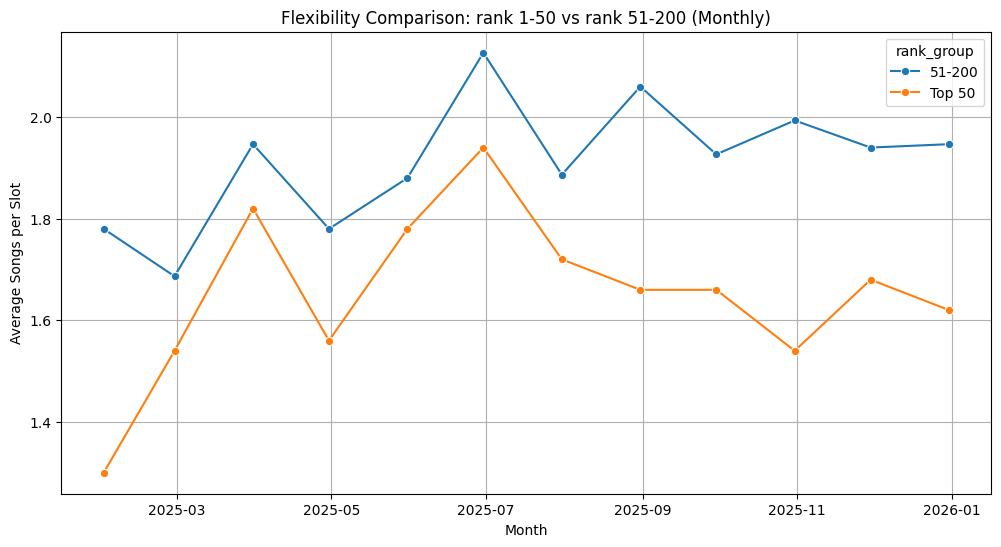

In [7]:
# 1. "상위권(1~50위)은 고착화되어 있지만, 중하위권(51~200위)은 날씨나 외부 요인에 민감하여 변동성이 크지 않을까???" - 라는 의문에서 시작
# 우선 변동성이 얼마나 큰지 보고싶은데?
# + 51~200은 150개의 곡을 포함하는 구간이고 in50은 50개만 포함하는 구간이면, 그 갭을 매꿔줘야 진정한 비교가 가능

def assign_rank_group_50(rank):
    if rank <= 50:
        return 'Top 50'
    else:
        return '51-200'

df_analysis = music_charts_df.copy()
df_analysis['rank_group'] = df_analysis['rank'].apply(assign_rank_group_50)

# (1) 구간별 슬롯 정의
slot_counts = {'Top 50': 50, '51-200': 150}     # 교체율 계산하기 위해서 (분모가 될 값)

# (2) 월별/구간별 유니크 곡 수 계산
flexibility_50_df = df_analysis.groupby([pd.Grouper(key='date', freq='ME'), 'rank_group'])['track_name'].nunique().reset_index()

# (3) '교체율' 산출
flexibility_50_df['turnover_rate'] = flexibility_50_df.apply(
    lambda x: x['track_name'] / slot_counts[x['rank_group']], axis=1
)

# (4) 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=flexibility_50_df, x='date', y='turnover_rate', hue='rank_group', marker='o')
plt.title('Flexibility Comparison: rank 1-50 vs rank 51-200 (Monthly)')
plt.ylabel('Average Songs per Slot')
plt.xlabel('Month')
plt.grid(True)
plt.show()

# 생각보다 변동성 차이가 크지 않다.

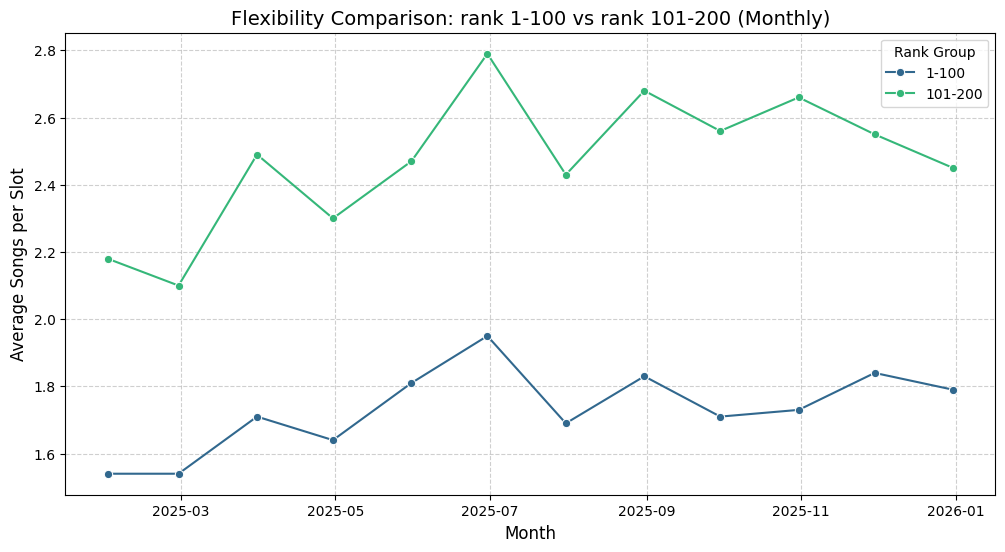

In [ ]:
# ~100위, ~200위 비교

def assign_rank_group_100(rank):
    if rank <= 100:
        return '1-100'
    else:
        return '101-200'

# 원본 데이터프레임 복사본 사용
df_analysis = music_charts_df.copy()
df_analysis['rank_group'] = df_analysis['rank'].apply(assign_rank_group_100)

# 3. 월별/그룹별 유니크 곡 수 계산
flexibility_100_df = df_analysis.groupby([pd.Grouper(key='date', freq='ME'), 'rank_group'])['track_name'].nunique().reset_index()

# 4. 교체율(Turnover Rate) 계산
flexibility_100_df['turnover_rate'] = flexibility_100_df['track_name'] / 100

# 5. 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=flexibility_100_df, x='date', y='turnover_rate', hue='rank_group', marker='o', palette='viridis')

plt.title('Flexibility Comparison: rank 1-100 vs rank 101-200 (Monthly)', fontsize=14)
plt.ylabel('Average Songs per Slot', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Rank Group')
plt.show()

In [9]:
# 랭킹이 101~200인 노래들만 선정하기

completed_101_200_df = completed_df[completed_df['rank']>100]
completed_101_200_df

,rank,artist_names,track_name,source,peak_rank,previous_rank,days_on_chart,streams,date,day_of_week,...,구름많음,흐림,안개,이슬비,소나기,비,진눈개비,눈,천둥번개,황사
98,101,고추잠자리,너라는 별,뷰티풀너드,53,102,32,9014,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0
99,102,NewJeans,ETA,ADOR,2,101,531,8985,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0
100,103,Lim Young Woong,A bientot,물고기뮤직,17,105,959,8805,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0
101,104,Lim Young Woong,Love Always Run Away,MOST CONTENTS,21,128,1147,8655,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0
102,105,LEECHANGSUB,Heavenly fate,TOON STUDIO,89,131,279,8599,2025-01-01,Wednesday,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71322,196,HANRORO,Don't be afraid to fall,authentic,158,-1,2,9625,2025-12-31,Wednesday,...,0,0,0,0,0,0,0,1,0,0
71323,197,Jin,Running Wild,BIGHIT MUSIC,2,190,388,9595,2025-12-31,Wednesday,...,0,0,0,0,0,0,0,1,0,0
71324,198,BABYMONSTER,Really Like You,YG Entertainment,140,175,5,9592,2025-12-31,Wednesday,...,0,0,0,0,0,0,0,1,0,0
71325,199,Mariah Carey,All I Want for Christmas Is You,Columbia,1,199,291,9591,2025-12-31,Wednesday,...,0,0,0,0,0,0,0,1,0,0


---

#### A-2. 하위권 차트를 통해 본 날씨의 주요 요소들과 음악의 주요 요소들간의 관계

In [10]:
# 일별로 그룹화
daily_df = completed_101_200_df.groupby('date').agg({
    'tempo': 'mean',
    'mean_mel': 'mean',
    'mean_centroid': 'mean',
    'temp_avg': 'first',
    'DI': 'first',
    'humidity_avg':'first'
}).reset_index()

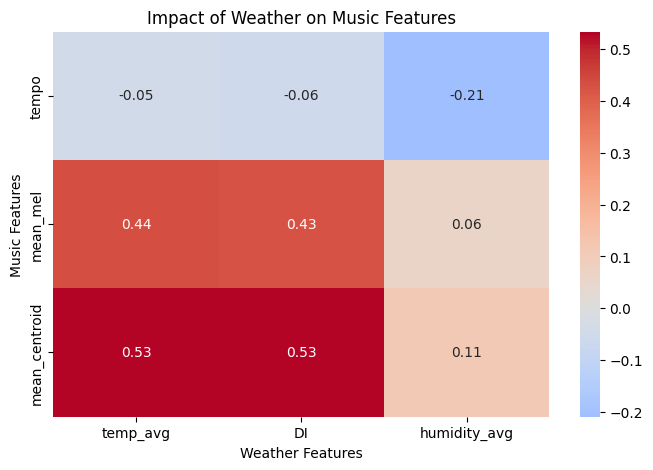

In [11]:
music_features = ['tempo', 'mean_mel', 'mean_centroid'] # 음악
weather_features = ['temp_avg', 'DI', 'humidity_avg']    # 날씨

# 2. 전체 상관계수를 구한 뒤, 원하는 행과 열만 추출
target_corr =  daily_df[music_features + weather_features].corr()
target_corr = target_corr.loc[music_features, weather_features]

# 3. 히트맵 그리기
plt.figure(figsize=(8, 5))
sns.heatmap(target_corr, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm',  # 파란색(음) ~ 흰색 ~ 빨간색(양)
            center=0)

plt.title('Impact of Weather on Music Features')
plt.xlabel('Weather Features')
plt.ylabel('Music Features')
plt.show()

---